This notebook is thought to be executed in Google colab, but ignoring this first cell can be executed in any jupyter environment.

In [2]:
!pip install -U -q PyDrive
!apt-get install -y libhdf5-serial-dev
!pip install tables

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials. get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass


file_list = drive.ListFile(
    {'q': "'11j5S_awb1RLtOH4OjCcw7zIzRUSo0SS3' in parents"}).GetList()

for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhdf5-serial-dev is already the newest version (1.10.0-patch1+docs-4).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
title: oo_data_region.hdf, id: 17FXh20y_J2TOyntDT4BezRXP3ZmDtKVR
downloading to /root/data/oo_data_region.hdf
title: oo_data.hdf, id: 1tHKK1UmvATNakHO43Ius3r7xP_w7I-bx
downloading to /root/data/oo_data.hdf


In [3]:
 
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
sns.set_palette("husl")
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import LSTM, LeakyReLU, CuDNNLSTM
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras import backend
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import regularizers
from keras import metrics
from keras.utils import np_utils
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline

Using TensorFlow backend.


Loading some helper functions and data

In [0]:
def score_classifier(predictions, y_test, y_prices_perc, model_name): 
    print('Accuracy:', accuracy_score(y_test, predictions ))
    avgret = y_prices_perc * predictions
    print('Return:', avgret.sum())
    avgret.cumsum().plot(label=model_name, legend=True)
    plt.show()
    
    y_prices_perc.plot(label='Real percentage change', legend=True)
    avgret.plot(label='Return', legend=True)  
    plt.show()

In [0]:
oo_df = pd.read_hdf('/root/data/oo_data_region.hdf', 'data')

oo_df['increase'] = np.sign(oo_df['price_perc'])
oo_jaen_df = oo_df[oo_df['provincia'] == 'JAEN']
provincia_encoder = preprocessing.LabelEncoder()
oo_df['provincia'] = provincia_encoder.fit_transform(oo_df['provincia'])

In [0]:
def create_dataset(test_size, include_columns=None, df=oo_df, test_column='price_perc'):
    train_df = df[:-test_size].reset_index(drop=True)
    test_df = df[-test_size:].reset_index(drop=True)
    y_train = train_df[test_column]
    y_test = test_df[test_column]
    y_last_prices = test_df['price-1w']
    y_prices_perc = test_df['price_perc']
    if include_columns:
        X_train = train_df[include_columns]
        X_test = test_df[include_columns]
    else:
        drop_columns = ['price_perc', 'price', 'increase', 'price_perc_medium']
        if test_column not in drop_columns:
            drop_columns.append(test_column)
        X_train = train_df.drop(columns=drop_columns)
        X_test = test_df.drop(columns=drop_columns)
    return X_train, y_train, X_test, y_test, y_last_prices, test_df['week_nr'], y_prices_perc

Creating dataset

In [0]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase', include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage',
                         ], df=oo_jaen_df
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = (y_train > 0).astype(int)

Let's test some architectures to check what is the optimal architecture

Accuracy: 0.6346153846153846
Return: 0.21397832772740166


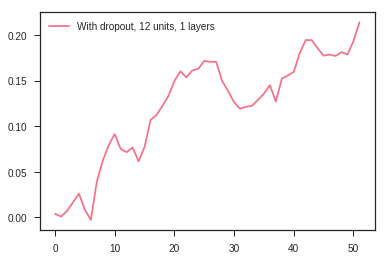

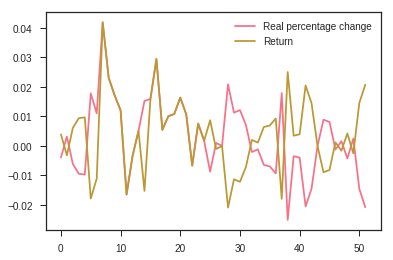

Accuracy: 0.5192307692307693
Return: -0.046687030698300214


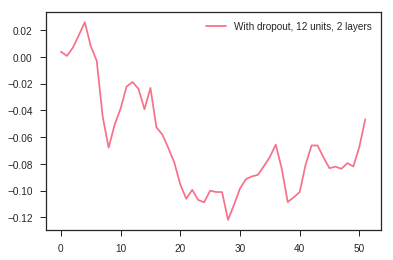

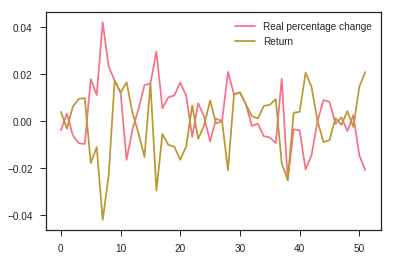

Accuracy: 0.5192307692307693
Return: -0.03682042264825801


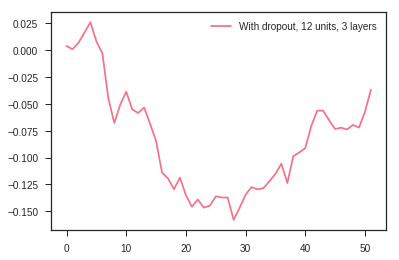

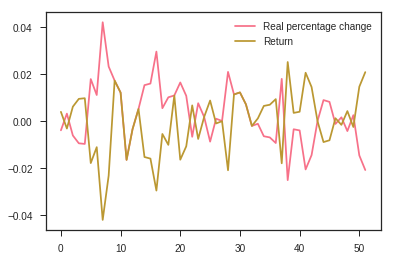

Accuracy: 0.5192307692307693
Return: -0.08831407531350455


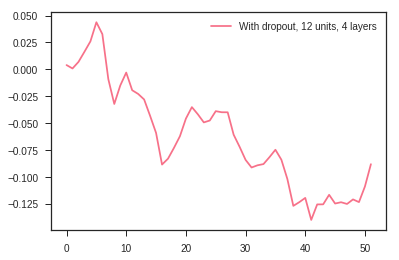

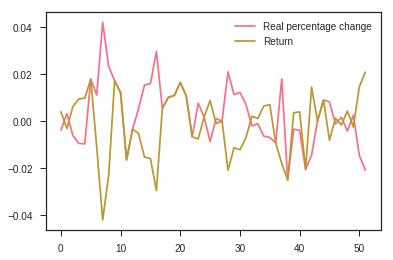

Accuracy: 0.5384615384615384
Return: 0.07133815640382184


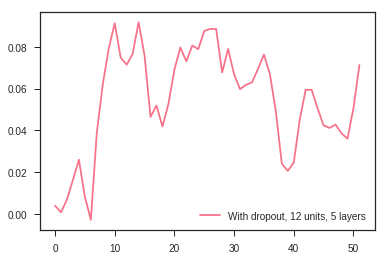

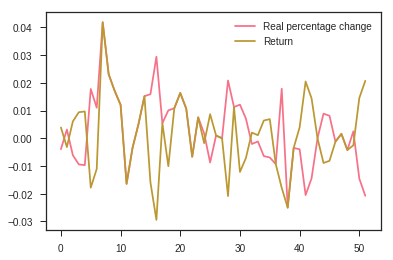

Accuracy: 0.5384615384615384
Return: 0.016523078502254672


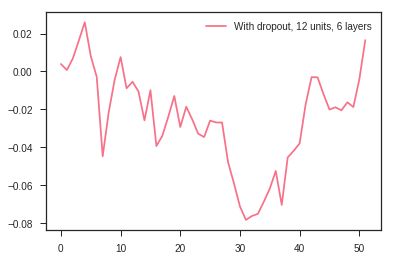

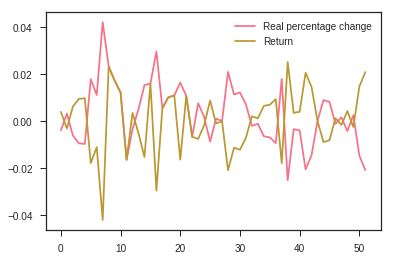

Accuracy: 0.5961538461538461
Return: 0.11721133549292836


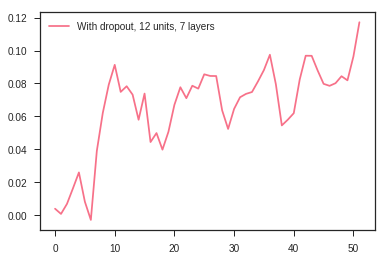

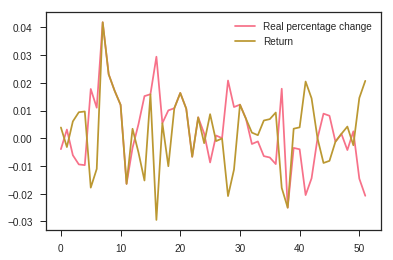

Accuracy: 0.5384615384615384
Return: 0.012429414869044413


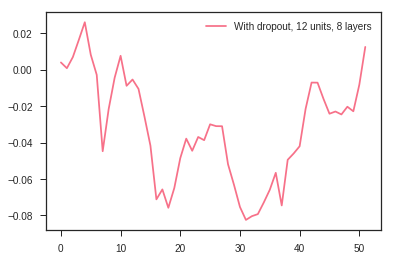

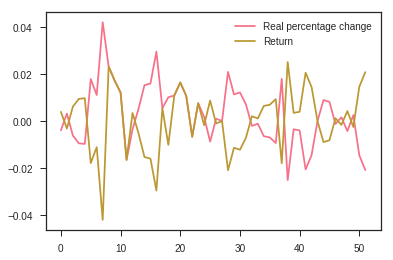

Accuracy: 0.5384615384615384
Return: 0.06836613721302637


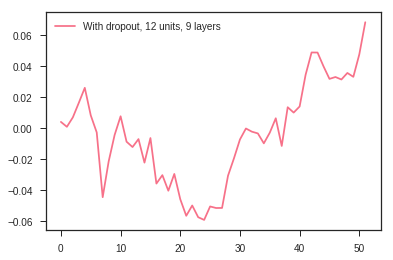

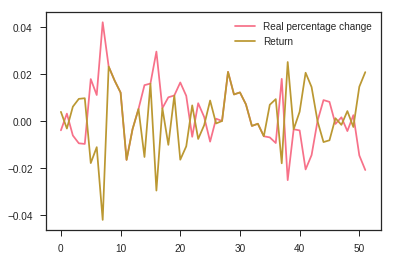

Accuracy: 0.5384615384615384
Return: 0.068536150288066


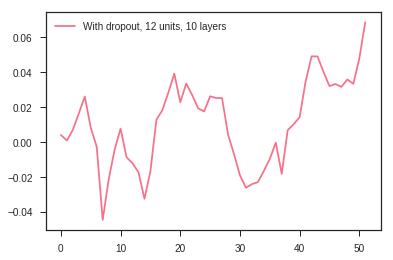

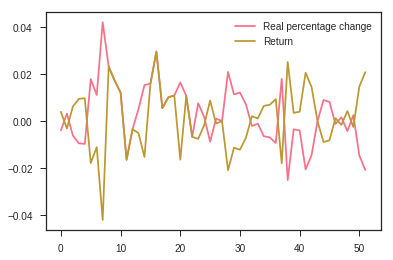

In [21]:
# Test some architectures
for nr_layer in range(1, 11):
  model = Sequential()
  model.add(Dense(units=8, activation='relu', input_shape=(X_train_scaled.shape[1],)))
  for i in range(nr_layer):
    model.add(Dense(units=12, activation='relu'))
    model.add(Dropout(0.1))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  history = model.fit(X_train_scaled, y_train, epochs=100, verbose=0,batch_size=50, validation_data=(X_test_scaled, y_test))
  predictions = model.predict_classes(X_test_scaled).reshape(1, X_test_scaled.shape[0])[0]
  predictions = [1 if prediction == 1 else -1 for prediction in list(predictions)]
  score_classifier(predictions, y_test, y_prices_perc, f'With dropout, 12 units, {nr_layer} layers')

Let's try with the chosen architecture with some layer units modifications. The chosen model is the one below, a 1 hidden layer model with dropout.

Accuracy: 0.6153846153846154
Return: 0.2498420115673992


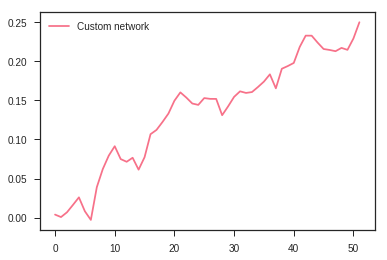

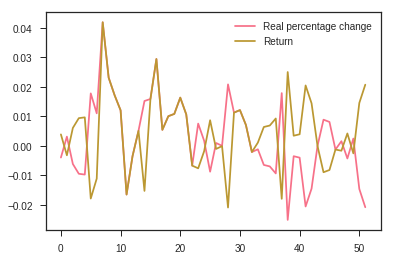

In [23]:
model = Sequential()
model.add(Dense(units=8, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=200, verbose=0, batch_size=52, validation_data=(X_test_scaled, y_test))
predictions = model.predict_classes(X_test_scaled).reshape(1, X_test_scaled.shape[0])[0]
predictions = [1 if prediction == 1 else -1 for prediction in list(predictions)]
score_classifier(predictions, y_test, y_prices_perc, f'Custom network')

It performs well but not better than the Random Forest classifier. Now, I'm going to test with LSTM neurons plus dense layers.

Accuracy: 0.6153846153846154
Return: 0.17132059448268022


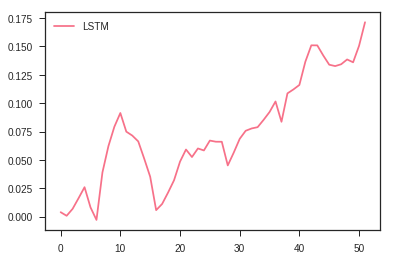

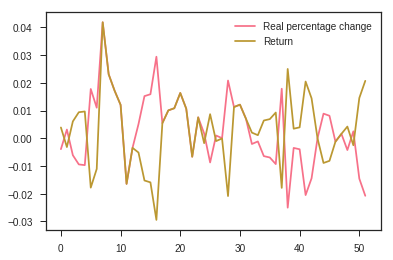

In [23]:
X_train_rs = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rs = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_rs.shape[1], X_train_rs.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, init='uniform', activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train_rs, y_train, epochs=100, verbose=0, batch_size=52, validation_data=(X_test_rs, y_test))
predictions = model.predict_classes(X_test_rs).reshape(1, X_test_scaled.shape[0])[0]
predictions = [1 if prediction == 1 else -1 for prediction in list(predictions)]
score_classifier(predictions, y_test, y_prices_perc, f'LSTM')

The results are similar. Now let's try with the full dataset, including other provinces.

In [0]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    300, test_column='increase', include_columns=['provincia','price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 
                                                 'freeze_damage', 'week_nr'
                         ], df=oo_df
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = (y_train > 0).astype(int)

Accuracy: 0.41333333333333333
Return: 1.1665520647291259


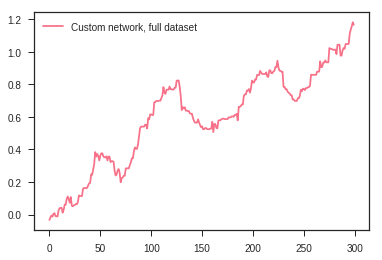

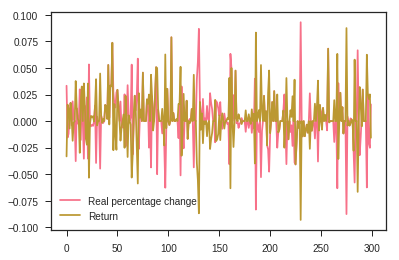

In [34]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=350, verbose=0, batch_size=200, validation_data=(X_test_scaled, y_test))
predictions = model.predict_classes(X_test_scaled).reshape(1, X_test_scaled.shape[0])[0]
predictions = [1 if prediction == 1 else -1 for prediction in list(predictions)]
score_classifier(predictions, y_test, y_prices_perc, f'Custom network, full dataset')

The results are worse, but not as bad as when I tried the full dataset in Random Forest / XGBClassifier. Now, I'm going to test with all the posible features instead of the selected ones.

In [0]:
X_train, y_train, X_test, y_test, y_last_prices, y_weeks_nr, y_prices_perc = create_dataset(
    52, test_column='increase', include_columns=[
        'price_perc-2w', 'price_perc-4w', 'price_perc-6w', 'price_perc-8w',
        'production_tons-1m_sum', 'production_tons-12m_sum', 'production_tons-3m_sum','production_tons-6m_sum', 'production_tons-9m_sum',
        'tmin', 'tmax', 'tmed', 'prec', 'racha', 'week_nr', 'prec-4w_sum', 'prec-13w_sum', 'prec-26w_sum', 'prec-52w_sum', 'tmed-4w_mean', 'freeze_damage', 
        'week_nr'
                         ], df=oo_jaen_df
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = (y_train > 0).astype(int)

In [10]:
oo_jaen_df.columns

Index(['price', 'provincia', 'price-1w', 'price-2w', 'price-4w', 'price+3w',
       'price-6w', 'price-8w', 'price-4w_mean', 'price-8w_mean', 'price_perc',
       'price_perc_medium', 'price_perc-2w', 'price_perc-4w', 'price_perc-6w',
       'price_perc-8w', 'tmin', 'tmax', 'tmed', 'prec', 'racha', 'week_nr',
       'prec-4w_sum', 'prec-13w_sum', 'prec-26w_sum', 'prec-52w_sum',
       'tmed-4w_mean', 'prec-4w_sum_perc', 'prec-13w_sum_perc',
       'prec-26w_sum_perc', 'prec-52w_sum_perc', 'tmed-4w_mean_perc',
       'tmin_perc', 'tmax_perc', 'tmed_perc', 'prec_perc', 'freeze_damage',
       'month', 'production_tons-1m_sum', 'production_tons-3m_sum',
       'production_tons-6m_sum', 'production_tons-9m_sum',
       'production_tons-12m_sum', 'production_tons-1m_sum_perc',
       'production_tons-3m_sum_perc', 'production_tons-6m_sum_perc',
       'production_tons-9m_sum_perc', 'production_tons-12m_sum_perc',
       'increase'],
      dtype='object')

Accuracy: 0.36538461538461536
Return: -0.16650891933518325


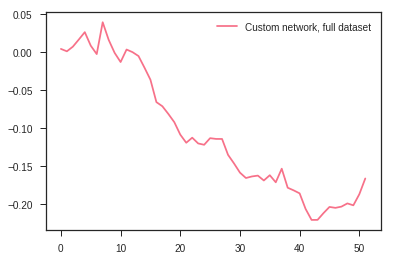

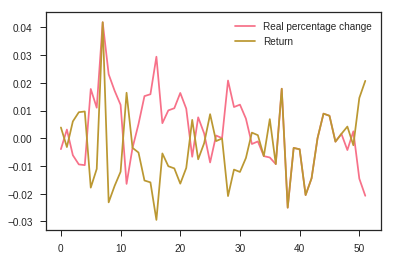

In [14]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=350, verbose=0, batch_size=50, validation_data=(X_test_scaled, y_test))
predictions = model.predict_classes(X_test_scaled).reshape(1, X_test_scaled.shape[0])[0]
predictions = [1 if prediction == 1 else -1 for prediction in list(predictions)]
score_classifier(predictions, y_test, y_prices_perc, f'Custom network, full dataset')

Even worse. Conclusions: doing a proper feature selection and data cleaning is crucial for the neural network